In [ ]:
#Vilka vingårdar har högst medelvärde?
#Har de största vinproducenterna fler viner med höga poäng?

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
from pyspark.sql import SparkSession
import seaborn as sns
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import pyspark.pandas as ps

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


Data cleaning

In [2]:
wine = pd.read_csv('winemag-data_first150k.csv', index_col=0)
#dtypes på kolumner country, province, variety och winery
wine['country']=wine['country'].astype('category')
wine['description']=wine['description'].astype('string')
wine['variety']=wine['variety'].astype('category')
wine['winery']=wine['winery'].astype('category')
wine.info()
wine = wine.drop(columns=["province", "region_1", "region_2", "designation"])
wine = wine.dropna(subset="country")
wine = wine.drop_duplicates(keep='first')
wine = wine.dropna(subset='price')
wine.reset_index(inplace=True)
wine.to_parquet('wine_parquet', index=False)

<class 'pandas.core.frame.DataFrame'>
Index: 150930 entries, 0 to 150929
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype   
---  ------       --------------   -----   
 0   country      150925 non-null  category
 1   description  150930 non-null  string  
 2   designation  105195 non-null  object  
 3   points       150930 non-null  int64   
 4   price        137235 non-null  float64 
 5   province     150925 non-null  object  
 6   region_1     125870 non-null  object  
 7   region_2     60953 non-null   object  
 8   variety      150930 non-null  category
 9   winery       150930 non-null  category
dtypes: category(3), float64(1), int64(1), object(4), string(1)
memory usage: 10.6+ MB


Select the 10 wineyards with highest average score
Diagram 1

In [3]:
#Diagram 1
spark = SparkSession.builder.getOrCreate()
parquetFile = spark.read.parquet("wine_parquet", flavor='spark')
parquetFile.createOrReplaceTempView("parquetFile")
query = "SELECT variety, winery, points FROM parquetFile"
df_wine = spark.sql(query)
df = df_wine.select("*").toPandas()
df = df[(df['points']>80)&(df['variety'])].groupby(['winery']).mean('points')
df_avg = df.sort_values('points', ascending=False)
df_avg10 = df_avg.head(10).reset_index()
wineries = df_avg10['winery'].unique()
df_avg10 = df.sort_values('points', ascending=True).tail(10)
df_avg10.reset_index(inplace=True)
points = df_avg10['points']

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/16 12:36:09 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Code to plot the results

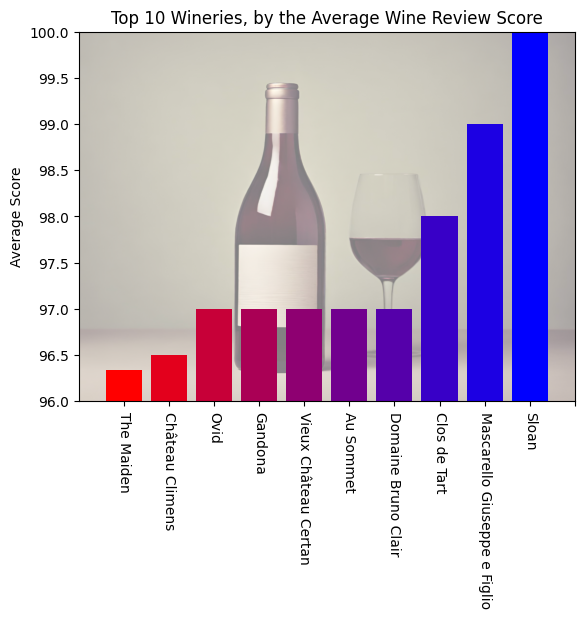

In [4]:
x = np.arange(0,11)
cmap = LinearSegmentedColormap.from_list(
    'red_blue', [(0, 'red'), (1, 'blue')])
colors = [cmap(i / 9) for i in range(10)]
fig, ax = plt.subplots()
xmin, xmax = plt.xlim()
plt.ylim(96,100)
img = plt.imread('wine.png')
winery = df_avg10['winery'] 
counts = df_avg10['points']
ax.bar(winery, counts, color=colors)
plt.imshow(img, extent=[xmin-1, xmax+9, 96, 100], aspect='auto', alpha=0.5)
ax.set_ylabel('Average Score')
ax.set_title('Top 10 Wineries, by the Average Wine Review Score')
plt.xticks(x, rotation=-90)
plt.show()


#Har de största vinproducenterna fler viner med höga poäng?

In [5]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pyarrow.parquet as pq
import pyarrow as pa
import pyspark.pandas as ps
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

spark = SparkSession.builder.getOrCreate()
parquetFile = spark.read.parquet("wine_parquet", flavor='spark')
parquetFile.createOrReplaceTempView("parquetFile")

query = "SELECT * FROM parquetFile"
wine = spark.sql(query)
wine = wine.select("*").toPandas()


Create an array with integers for each producer for the plots, each producer have their own section for queries and plots

In [6]:
def assign_unique_integers(strings):
    unique_strings = sorted(set(strings))  # Get unique strings and sort them
    # Create a dictionary mapping each unique string to a unique integer value
    string_to_integer = {string: i for i, string in enumerate(unique_strings)}
    # Create a vector where each element corresponds to the integer value of its corresponding string
    integer_vector = [string_to_integer[string] for string in strings]
    return integer_vector, string_to_integer

'Williams Selyem' Diagram 2

In [7]:
winerySQL1 = 'Williams Selyem'
query_winery = f"SELECT * FROM parquetFile where winery='{winerySQL1}'"
winery_1 = spark.sql(query_winery)
winery_1 = winery_1.select("*").toPandas()
winery_1['variety'].count()
winery_1['points'].describe()
winery_1['points'].isna().unique()

integer_vector, string_to_integer = assign_unique_integers(winery_1['variety'])
print("String to integer mapping:", string_to_integer)

String to integer mapping: {'Chardonnay': 0, 'Chenin Blanc': 1, 'Gewürztraminer': 2, 'Muscat': 3, 'Pinot Noir': 4, 'Port': 5, 'Sparkling Blend': 6, 'Zinfandel': 7}


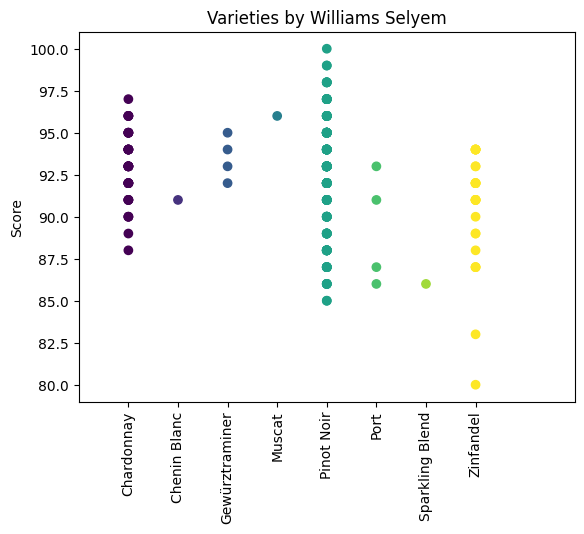

In [8]:
fig, ax = plt.subplots()
x = np.arange(0,len(winery_1['variety'].unique()))
xmin, xmax = plt.xlim(-1,len(winery_1['variety'].unique())+1)
variety = winery_1['variety'] 
counts = winery_1['points']
ax.scatter(integer_vector, winery_1['points'], c=integer_vector)
ax.set_ylabel('Score')
ax.set_title(f'Varieties by {winerySQL1}')
ax.set_xticks(x)
ax.set_xticklabels(string_to_integer, rotation=90)
plt.show()

'Testarossa' Diagram 3

In [9]:
winerySQL2 = 'Testarossa'
query_winery = f"SELECT * FROM parquetFile where winery='{winerySQL2}'"
winery_2 = spark.sql(query_winery)
winery_2 = winery_2.select("*").toPandas()
winery_2['variety'].count()
winery_2['points'].describe()
winery_2['points'].isna().unique()

integer_vector, string_to_integer = assign_unique_integers(winery_2['variety'])
print("String to integer mapping:", string_to_integer)

String to integer mapping: {'Chardonnay': 0, 'Pinot Noir': 1, 'Sauvignon Blanc': 2, 'Syrah': 3}


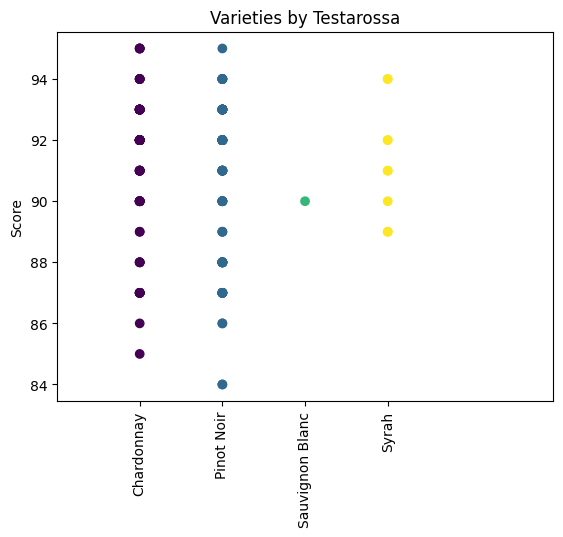

In [10]:
fig, ax = plt.subplots()
x = np.arange(0,len(winery_2['variety'].unique()))
xmin, xmax = plt.xlim(-1,len(winery_2['variety'].unique())+1)
variety = winery_2['variety'] 
counts = winery_2['points']
ax.scatter(integer_vector, winery_2['points'], c=integer_vector)
ax.set_ylabel('Score')
ax.set_title(f'Varieties by {winerySQL2}')
ax.set_xticks(x)
ax.set_xticklabels(string_to_integer, rotation=90)
plt.show()

'Chateau Ste. Michelle' Diagram 4

In [ ]:
winerySQL3 = 'Chateau Ste. Michelle'
query_winery = f"SELECT * FROM parquetFile where winery='{winerySQL3}'"
winery_3 = spark.sql(query_winery)
winery_3 = winery_3.select("*").toPandas()
winery_3['variety'].count()
winery_3['points'].describe()
integer_vector, string_to_integer = assign_unique_integers(winery_3['variety'])
print("String to integer mapping:", string_to_integer)

In [ ]:
fig, ax = plt.subplots()
x = np.arange(0,len(winery_3['variety'].unique()))
xmin, xmax = plt.xlim(-1,len(winery_3['variety'].unique())+1)
variety = winery_3['variety'] 
counts = winery_3['points']
ax.scatter(integer_vector, winery_3['points'], c=integer_vector)
ax.set_ylabel('Score')
ax.set_title(f'Varieties by {winerySQL3}')
ax.set_xticks(x)
ax.set_xticklabels(string_to_integer, rotation=90)
plt.show()

'Columbia Crest' Diagram 5

In [ ]:
winerySQL4 = 'Columbia Crest'
query_winery = f"SELECT * FROM parquetFile where winery='{winerySQL4}'"
winery_4 = spark.sql(query_winery)
winery_4 = winery_4.select("*").toPandas()
winery_4['variety'].count()
winery_4['points'].describe()
integer_vector, string_to_integer = assign_unique_integers(winery_4['variety'])
print("String to integer mapping:", string_to_integer)

In [ ]:
fig, ax = plt.subplots()
x = np.arange(0,len(winery_4['variety'].unique()))
xmin, xmax = plt.xlim(-1,len(winery_4['variety'].unique())+1)
variety = winery_4['variety'] 
counts = winery_4['points']
ax.scatter(integer_vector, winery_4['points'], c=integer_vector)
ax.set_ylabel('Score')
ax.set_title(f'Varieties by {winerySQL4}')
ax.set_xticks(x)
ax.set_xticklabels(string_to_integer, rotation=90)
plt.show()

'DFJ Vinhos' Diagram 6

In [ ]:
winerySQL5 = 'DFJ Vinhos'
query_winery = f"SELECT * FROM parquetFile where winery='{winerySQL5}'"
winery_5= spark.sql(query_winery)
winery_5 = winery_5.select("*").toPandas()
winery_5['variety'].count()
winery_5['points'].describe()
integer_vector, string_to_integer = assign_unique_integers(winery_5['variety'])
print("String to integer mapping:", string_to_integer)

In [ ]:
fig, ax = plt.subplots()
x = np.arange(0,len(winery_5['variety'].unique()))
xmin, xmax = plt.xlim(-1,len(winery_5['variety'].unique())+1)
variety = winery_5['variety'] 
counts = winery_5['points']
ax.scatter(integer_vector, winery_5['points'], c=integer_vector)
ax.set_ylabel('Score')
ax.set_title(f'Varieties by {winerySQL5}')
ax.set_xticks(x)
ax.set_xticklabels(string_to_integer, rotation=90)
plt.show()

'Concha y Toro' Diagram 7

In [ ]:
winerySQL6 = 'Concha y Toro'
query_winery = f"SELECT * FROM parquetFile where winery='{winerySQL6}'"
winery_6= spark.sql(query_winery)
winery_6 = winery_6.select("*").toPandas()
winery_6['variety'].count()
winery_6['points'].describe()
integer_vector, string_to_integer = assign_unique_integers(winery_6['variety'])
print("String to integer mapping:", string_to_integer)

In [ ]:
fig, ax = plt.subplots()
x = np.arange(0,len(winery_6['variety'].unique()))
xmin, xmax = plt.xlim(-1,len(winery_6['variety'].unique())+1)
variety = winery_6['variety'] 
counts = winery_6['points']
ax.scatter(integer_vector, winery_6['points'], c=integer_vector)
ax.set_ylabel('Score')
ax.set_title(f'Varieties by {winerySQL6}')
ax.set_xticks(x)
ax.set_xticklabels(string_to_integer, rotation=90)
plt.show()

'Kendall-Jackson' Diagram 8

In [ ]:
winerySQL8='Kendall-Jackson'
query_winery = f"SELECT * FROM parquetFile where winery='{winerySQL8}'"
winery_8= spark.sql(query_winery)
winery_8 = winery_8.select("*").toPandas()
winery_8['variety'].count()
winery_8['points'].describe()
integer_vector, string_to_integer = assign_unique_integers(winery_8['variety'])
print("String to integer mapping:", string_to_integer)

In [ ]:
fig, ax = plt.subplots()
x = np.arange(0,len(winery_8['variety'].unique()))
xmin, xmax = plt.xlim(-1,len(winery_8['variety'].unique())+1)
variety = winery_8['variety'] 
counts = winery_8['points']
ax.scatter(integer_vector, winery_8['points'], c=integer_vector)
ax.set_ylabel('Score')
ax.set_title(f'Varieties by {winerySQL8}')
ax.set_xticks(x)
ax.set_xticklabels(string_to_integer, rotation=90)
plt.show()

'Joseph Drouhin' Diagram 9

In [ ]:
winerySQL9='Joseph Drouhin'
query_winery = f"SELECT * FROM parquetFile where winery='{winerySQL9}'"
winery_9= spark.sql(query_winery)
winery_9 = winery_9.select("*").toPandas()
winery_9['variety'].count()
winery_9['points'].describe()
integer_vector, string_to_integer = assign_unique_integers(winery_9['variety'])
print("String to integer mapping:", string_to_integer)

In [ ]:
fig, ax = plt.subplots()
x = np.arange(0,len(winery_9['variety'].unique()))
xmin, xmax = plt.xlim(-1,len(winery_9['variety'].unique())+1)
variety = winery_9['variety'] 
counts = winery_9['points']
ax.scatter(integer_vector, winery_9['points'], c=integer_vector)
ax.set_ylabel('Score')
ax.set_title(f'Varieties by {winerySQL9}')
ax.set_xticks(x)
ax.set_xticklabels(string_to_integer, rotation=90)
plt.show()

'Trapiche' Diagram 10

In [ ]:
winerySQL10='Trapiche'
query_winery = f"SELECT points, variety FROM parquetFile where winery='{winerySQL10}'"
winery_10= spark.sql(query_winery)
winery_10 = winery_10.select("*").toPandas()
winery_10['variety'].count()
winery_10['points'].describe()
integer_vector, string_to_integer = assign_unique_integers(winery_10['variety'])
print("String to integer mapping:", string_to_integer)

In [ ]:
fig, ax = plt.subplots()
x = np.arange(0,len(winery_10['variety'].unique()))
varieties_unique = winery_10['variety'].unique()
xmin, xmax = plt.xlim(-1,len(winery_10['variety'].unique())+1)
variety = winery_10['variety'] 
counts = winery_10['points']
ax.scatter(integer_vector, winery_10['points'], c=integer_vector)
ax.set_ylabel('Score')
ax.set_title(f'Varieties by {winerySQL10}')
ax.set_xticks(x)
ax.set_xticklabels(string_to_integer, rotation=90)
plt.show()

'Louis Latour' Diagram 11

In [ ]:
winerySQL7 ='Louis Latour'
query_winery = f"SELECT * FROM parquetFile where winery='{winerySQL7}'"
winery_7= spark.sql(query_winery)
winery_7 = winery_7.select("*").toPandas()
winery_7['variety'].count()
winery_7['points'].describe()
integer_vector, string_to_integer = assign_unique_integers(winery_7['variety'])
print("String to integer mapping:", string_to_integer)

In [ ]:
fig, ax = plt.subplots()
x = np.arange(0,len(winery_7['variety'].unique()))
xmin, xmax = plt.xlim(-1,len(winery_7['variety'].unique())+1)
variety = winery_7['variety'] 
counts = winery_7['points']
ax.scatter(integer_vector, winery_7['points'], c=integer_vector)
ax.set_ylabel('Score')
ax.set_title(f'Varieties by {winerySQL7}')
ax.set_xticks(x)
ax.set_xticklabels(string_to_integer, rotation=90)
plt.show()

In [ ]:
spark.stop()